In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import qutip
from scipy.linalg import sqrtm

from povm_clf import *

---
# 1. Funtions in povm_clf

## 1-1. State Preparation

### Mixed states

In [2]:
test = State_Preparation(bloch_vec=[0.7,0,0])

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.7, 0, 0]
Output Bloch vector =  [0.70165015 0.00198782 0.00132609]


* Circuit Diagram

In [3]:
dev = qml.device('default.qubit', wires=2)
@qml.qnode(dev)
def circ_test():
    test.on_circuit(wires=[0,1]) #요거 그림 그려보기!
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))
circ_test()

tensor(0.17915876, requires_grad=True)

(<Figure size 432x216 with 1 Axes>, <Axes:>)

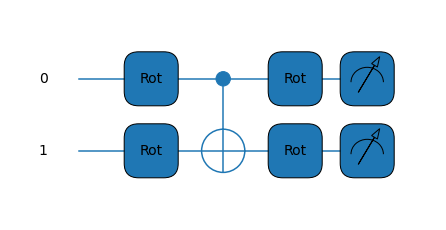

In [5]:
qml.draw_mpl(circ_test)()

---
# 2. Pure-state Classifier

##  Two-element POVM

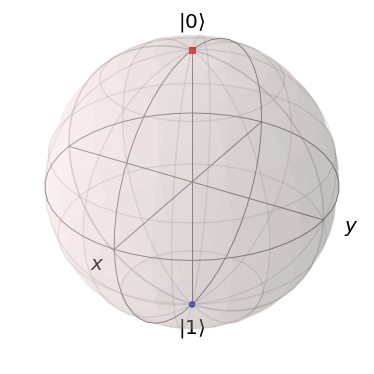

In [10]:
n = 2
devs = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1]

a_priori_probs = [1/n] * n
#bloch_vecs = [[0,1,0], [0,-1,0]]
bloch_vecs = [[0,0,-1],[0,0,1]]
rho_prepared = [State_Preparation(bloch_vecs[i]).on_circuit for i in range(n)]


# Visualization
bloch_sphere = qutip.Bloch()
for i in range(n):
    bloch_sphere.add_points(bloch_vecs[i])
bloch_sphere.show()

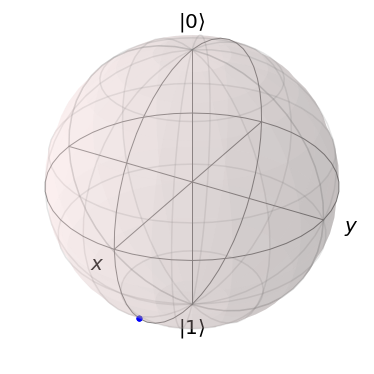

In [20]:
bloch_sphere = qutip.Bloch()
bloch_sphere.add_points(state_2_bloch([0.38268343, 0.92387953]))
bloch_sphere.show()

In [11]:
classifier = POVM_Clf(n, wires, devs, a_priori_probs, rho_prepared, 0)

# Simulation
steps=400
cost_list = classifier.run_opt(steps)

Cost(init_params)    : 0.4900850
Cost after step    20:  0.0371729
Cost after step    40:  0.0005940
Cost after step    60:  0.0000088
Cost after step    80:  0.0000001
Cost after step   100:  0.0000000
Cost after step   120:  0.0000000
Cost after step   140:  0.0000000
Cost after step   160:  0.0000000
Cost after step   180:  0.0000000
Cost after step   200:  0.0000000
Cost after step   220:  0.0000000
Cost after step   240:  0.0000000
Cost after step   260:  0.0000000
Cost after step   280:  0.0000000
Cost after step   300:  0.0000000
Cost after step   320:  0.0000000
Cost after step   340:  0.0000000
Cost after step   360:  0.0000000
Cost after step   380:  0.0000000
Cost after step   400:  0.0000000


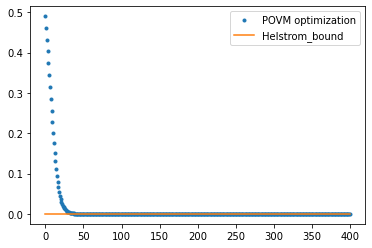

In [12]:
density_matrices = [bloch_2_state(bloch_vecs[i], 'density') for i in range(n)]

plt.plot(list(range(steps+1)), cost_list, '.', label='POVM optimization')

Helstrom_bound, Helstrom_povm = Helstrom(a_priori_probs, density_matrices)
plt.plot(list(range(steps+1)), [Helstrom_bound]*(steps+1), '-', label="Helstrom_bound")
plt.legend()
plt.show()

In [13]:
rho_tot = 2 * np.array([[3/4,1/4],[1/4,1/4]])
res = np.linalg.inv(sqrtm(rho_tot))
#res = res / np.sqrt(2)
res

tensor([[ 0.92387953, -0.38268343],
        [-0.38268343,  1.6892464 ]], requires_grad=True)

In [14]:
np.dot(res[1,:], [1/np.sqrt(2),1/np.sqrt(2)])

0.923879532511287

In [15]:
state = np.dot(res, [1/np.sqrt(2),1/np.sqrt(2)])
state

tensor([0.38268343, 0.92387953], requires_grad=True)

In [16]:
sqrtm(np.linalg.inv(rho_tot)) / np.sqrt(2)

array([[ 0.65328148, -0.27059805],
       [-0.27059805,  1.19447758]])

In [18]:
rho = density_matrices
K = classifier.kraus_op()
E = classifier.povm_matrices()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
pgms, med_pgm = pgm(a_priori_probs, rho)
print("Minimum-Error Discrimination")
print("performed optimal POVM:", med_povm)
print("performed PGM:", med_pgm)

dp_res(rho, E=E, PGM=pgms)

Minimum-Error Discrimination
performed optimal POVM: 0.0
performed PGM: 2.220446049250313e-16


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,,0.0000+0.0000j,0.0000+0.0000j,
,0.0000+0.0000j,1.0000+0.0000j,0.0000-0.0000j,1.0000+0.0000j,1.0000,0.0000+0.0000j,1.0000+0.0000j,1.0000
i=1,1.0000+0.0000j,0.0000+0.0000j,1.0000-0.0000j,-0.0000-0.0000j,,1.0000+0.0000j,0.0000+0.0000j,
,0.0000+0.0000j,0.0000+0.0000j,-0.0000+0.0000j,0.0000-0.0000j,1.0000,0.0000+0.0000j,0.0000+0.0000j,1.0000


## Three-element POVM

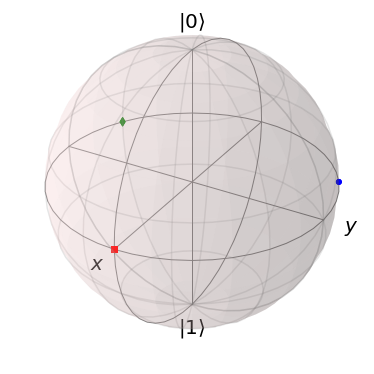

In [2]:
n = 3
devs = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1, 2]


a_priori_probs = [1/n] * n
state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
#state_vecs = [[1, 0], [0, 1], [1/np.sqrt(2), 1/np.sqrt(2)]]

bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)]
rho_prepared = [State_Preparation(bloch_vecs[i]).on_circuit for i in range(n)]


# Visualization
bloch_sphere = qutip.Bloch()
for i in range(n):
    bloch_sphere.add_points(bloch_vecs[i])
bloch_sphere.show()

In [3]:
classifier = POVM_Clf(n, wires, devs, a_priori_probs, rho_prepared, 0)

In [4]:
classifier.qnodes(2 * np.pi * np.random.random([(5 * (n-1))])).shape

(3, 4)

In [5]:
classifier = POVM_Clf(n, wires, devs, a_priori_probs, rho_prepared, 0)
#pgm, cost_pgm = classifier.pgm()
#print("Cost fn based on PGM:", cost_pgm)

# Simulation
steps = 150
cost_list = classifier.run_opt(steps)

Cost(init_params)    : 0.6587639
Cost after step    20:  0.5837702
Cost after step    40:  0.4249980
Cost after step    60:  0.3888514
Cost after step    80:  0.3828349
Cost after step   100:  0.3805938
Cost after step   120:  0.3794194
Cost after step   140:  0.3787725


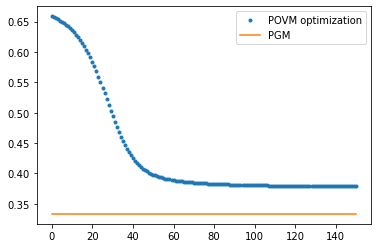

In [9]:
density_matrices = [bloch_2_state(bloch_vecs[i], 'density') for i in range(n)]

plt.plot(list(range(steps+1)), cost_list, '.', label='POVM optimization')
cost_pgm, pgms = pgm(a_priori_probs, density_matrices)
plt.plot(list(range(steps+1)), [cost_pgm]*(steps+1), '-', label="PGM")
plt.legend()
plt.show()

In [28]:
num = 8
int(np.ceil(np.log(num) / np.log(2)))

3

In [9]:
rho = density_matrices
K = classifier.kraus_op()
E = classifier.povm_matrices()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
print("Minimum-Error Discrimination")
print("performed optimal POVM:", med_povm)
print("performed PGM:", cost_pgm)

dp_res(rho, E=E, PGM=pgms)

Minimum-Error Discrimination
performed optimal POVM: 0.7776054801212093
performed PGM: 0.3333333333333335


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,0.5000+0.0000j,-0.2500-0.4330j,0.6672+0.0000j,0.1697+0.2863j,,0.3333-0.0000j,-0.1667-0.2887j,
,-0.2500+0.4330j,0.5000+0.0000j,0.1697-0.2863j,0.6672-0.0000j,0.3344,-0.1667+0.2887j,0.3333-0.0000j,0.6667
i=1,0.5000+0.0000j,0.5000+0.0000j,0.3307+0.0000j,-0.1668+0.2855j,,0.3333+0.0000j,0.3333+0.0000j,
,0.5000+0.0000j,0.5000+0.0000j,-0.1668-0.2855j,0.3307+0.0000j,0.1639,0.3333+0.0000j,0.3333+0.0000j,0.6667
i=2,0.5000+0.0000j,-0.2500+0.4330j,0.3365+0.0000j,0.3365+0.0008j,,0.3333+0.0000j,-0.1667+0.2887j,
,-0.2500-0.4330j,0.5000+0.0000j,0.3365-0.0008j,0.3365+0.0000j,0.1689,-0.1667-0.2887j,0.3333+0.0000j,0.6667


---
# 3. Mixed-state Classifier

## Two-element POVM

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.2, 0, 0]
Output Bloch vector =  [ 2.00386358e-01 -1.26967308e-04 -6.97101254e-04]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0, 0, 0.2]
Output Bloch vector =  [-0.00110388  0.00024408  0.20144428]


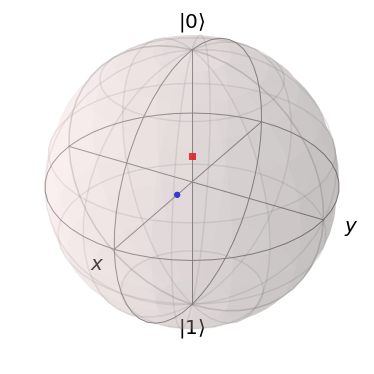

In [19]:
n = 2
n_qubit = n + 1
devs = [qml.device('default.qubit', wires=n_qubit)] * n
wires = [0, 1]

# Input State Information
a_priori_probs = [1/n] * n
bloch_vecs = [[0.2,0,0], [0,0,0.2]]
rho_prepared = [State_Preparation(bloch_vecs[i]).on_circuit for i in range(n)]
state_wires = [0, 2]

# Visualization
bloch_sphere = qutip.Bloch()
for i in range(n):
    bloch_sphere.add_points(bloch_vecs[i])
bloch_sphere.show()

In [20]:
classifier = POVM_Clf(n, wires, devs, a_priori_probs, rho_prepared, state_wires)

In [21]:
steps=400
cost_list = classifier.run_opt(steps)

Cost(init_params)    : 0.4989861
Cost after step    20:  0.4926172
Cost after step    40:  0.4849449
Cost after step    60:  0.4753252
Cost after step    80:  0.4642240
Cost after step   100:  0.4533281
Cost after step   120:  0.4444200
Cost after step   140:  0.4381693
Cost after step   160:  0.4342076
Cost after step   180:  0.4318374
Cost after step   200:  0.4304610
Cost after step   220:  0.4296736
Cost after step   240:  0.4292265
Cost after step   260:  0.4289738
Cost after step   280:  0.4288311
Cost after step   300:  0.4287508
Cost after step   320:  0.4287055
Cost after step   340:  0.4286800
Cost after step   360:  0.4286657
Cost after step   380:  0.4286576
Cost after step   400:  0.4286530


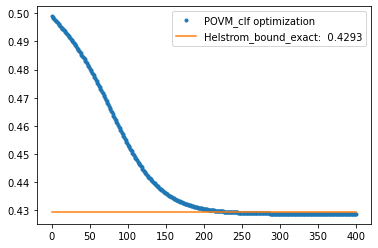

In [28]:
density_matrices = [bloch_2_state(bloch_vecs[i], 'density') for i in range(n)]

plt.plot(list(range(steps+1)), cost_list, '.', label='POVM_clf optimization')

Helstrom_bound_exact, opt_povms = Helstrom(a_priori_probs, density_matrices)
plt.plot(list(range(steps+1)), [Helstrom_bound_exact]*(steps+1), '-', label="Helstrom_bound_exact: {: .4f}".format(Helstrom_bound_exact))
#plt.plot(list(range(steps+1)), [Helstrom_bound_noisy]*(steps+1), '-', label="Helstrom_bound_noisy: {: .4f}".format(Helstrom_bound_noisy))
plt.legend()
plt.show()

In [29]:
rho = density_matrices
K = classifier.kraus_op()
E = classifier.povm_matrices()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
pgms, med_pgm = pgm(a_priori_probs, rho)
print("=== Minimum-Error Discrimination ===")
print("by performing optimal POVM:", med_povm)
print("by performing PGM:", med_pgm)

dp_res(rho, E=E, PGM=pgms)

=== Minimum-Error Discrimination ===
by performing optimal POVM: 0.4292953455576034
by performing PGM: 0.4898984745544773


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,0.5000+0.0000j,0.1000+0.0000j,0.1459-0.0000j,0.3529+0.0010j,,0.4495+0.0000j,0.0505+0.0000j,
,0.1000+0.0000j,0.5000+0.0000j,0.3529-0.0010j,0.8542+0.0000j,0.5706,0.0505+0.0000j,0.5505+0.0000j,0.5101
i=1,0.6000+0.0000j,0.0000+0.0000j,0.8541-0.0000j,-0.3529-0.0010j,,0.5505+0.0000j,-0.0505+0.0000j,
,0.0000+0.0000j,0.4000+0.0000j,-0.3529+0.0010j,0.1458-0.0000j,0.5708,-0.0505+0.0000j,0.4495+0.0000j,0.5101


## Three-element POVM

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.3999999999999999, 0.692820323027551, -1.2864981197413094e-16]
Output Bloch vector =  [-3.98774011e-01  6.91297511e-01 -3.62660517e-05]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.8, 0.0, -1.2864981197413094e-16]
Output Bloch vector =  [ 7.99611397e-01  2.07755123e-03 -2.64110015e-04]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.3999999999999999, -0.692820323027551, -1.2864981197413094e-16]
Output Bloch vector =  [-3.99589545e-01 -6.93146189e-01 -1.92424828e-04]


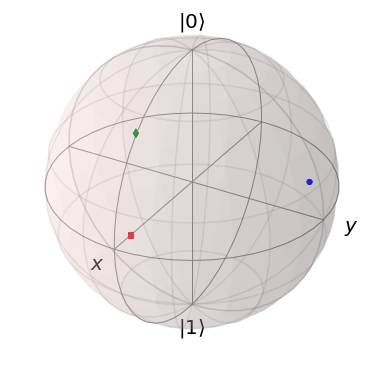

In [6]:
n = 3
n_qubit = n + 1
devs = [qml.device('default.qubit', wires=n_qubit)] * n
wires = [0, 1, 2]


a_priori_probs = [1/n] * n
state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)]
bloch_vecs = [[0.8 * bloch_vecs[n][i] for i in range(3)] for n in range(n)]
rho_prepared = [State_Preparation(bloch_vecs[i]).on_circuit for i in range(n)]
state_wires = [0, 3]

# Visualization
bloch_sphere = qutip.Bloch()
for i in range(n):
    bloch_sphere.add_points(bloch_vecs[i])
bloch_sphere.show()

In [7]:
classifier = POVM_Clf(n, wires, devs, a_priori_probs, rho_prepared, state_wires)

In [8]:
steps=600
cost_list = classifier.run_opt(steps)

Cost(init_params)    : 0.7303439
Cost after step    20:  0.6210473
Cost after step    40:  0.5004621
Cost after step    60:  0.4515293
Cost after step    80:  0.4398830
Cost after step   100:  0.4366112
Cost after step   120:  0.4351696
Cost after step   140:  0.4339006
Cost after step   160:  0.4321728
Cost after step   180:  0.4294382
Cost after step   200:  0.4250969
Cost after step   220:  0.4189483
Cost after step   240:  0.4120582
Cost after step   260:  0.4064224
Cost after step   280:  0.4030217
Cost after step   300:  0.4013772
Cost after step   320:  0.4006822
Cost after step   340:  0.4004104
Cost after step   360:  0.4003086
Cost after step   380:  0.4002712


In [13]:
(len(cost_list)+1)

386

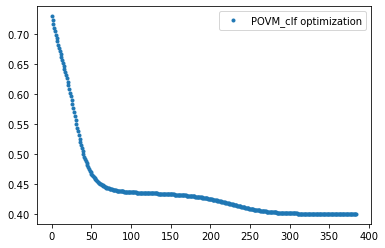

In [16]:
density_matrices = [bloch_2_state(bloch_vecs[i], 'density') for i in range(n)]

plt.plot(range(len(cost_list)), cost_list, '.', label='POVM_clf optimization')
pgms, cost_pgm = pgm(a_priori_probs, density_matrices)
#plt.plot(range(len(cost_list)), [cost_pgm]*(len(cost_list)), '-', label="PGM")
plt.legend()
plt.show()

In [53]:
rho = density_matrices
K = classifier.kraus_op()
E = classifier.povm()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
pgms, med_pgm = pgm(a_priori_probs, density_matrices)
print("=== Minimum-Error Discrimination ===")
print("by performing optimal POVM:", med_povm)
print("by performing PGM:", med_pgm)

dp_res(rho, E=E, PGM=pgms, )

=== Minimum-Error Discrimination ===
by performing optimal POVM: 0.44739543326855635
by performing PGM: 0.45333333333333337


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,0.5000+0.0000j,-0.2000-0.3464j,1.0000+0.0000j,-0.0000-0.0000j,,0.3333-0.0000j,-0.1333-0.2309j,
,-0.2000+0.3464j,0.5000+0.0000j,-0.0000+0.0000j,1.0000+0.0000j,1.0000,-0.1333+0.2309j,0.3333-0.0000j,0.5467
i=1,0.5000+0.0000j,0.4000+0.0000j,0.5012+0.0000j,-0.4312-0.2530j,,0.3333+0.0000j,0.2667+0.0000j,
,0.4000+0.0000j,0.5000+0.0000j,-0.4312+0.2530j,0.4988-0.0000j,0.1550,0.2667+0.0000j,0.3333+0.0000j,0.5467
i=2,0.5000+0.0000j,-0.2000+0.3464j,0.4988-0.0000j,0.4312+0.2530j,,0.3333+0.0000j,-0.1333+0.2309j,
,-0.2000-0.3464j,0.5000+0.0000j,0.4312-0.2530j,0.5012-0.0000j,0.5028,-0.1333-0.2309j,0.3333+0.0000j,0.5467


---
Check Validity of Optimality Conditions

In [33]:
i, j = 0, 1
np.dot(np.dot(pgm[i], rho[i] - rho[j]), pgm[j])

tensor([[ 1.66533454e-18-7.43675472e-18j,
         -2.40000000e-02-1.38564065e-02j],
        [-2.40000000e-02+1.38564065e-02j,
          1.55431223e-17-1.76014679e-18j]], requires_grad=True)

In [34]:
i, j = 1, 2
np.dot(np.dot(E[i], rho[i] - rho[j]), E[j])

tensor([[-0.00037861+0.000953j  , -0.0006277 -0.00080901j],
        [-0.00037498+0.00095491j, -0.00063118-0.00080685j]], requires_grad=True)